# PROJECT. Оценка эффективности новой фичи.

## Постановка задачи, описание исходных данных и подхода к решению задачи.
**Общая задача** - оценить влияние нового релиза личного кабинета клиента на сайте клиниговой кампании.  

**Требуется**:
1. Посчитать показатели Retention Rate седьмого дня и ARPPU за два периода: до и после внедрения нового релиза.
2. Сформировать выводы по анализу.  

**Исходные данные**:  
Три таблицы в SQL базе данных:
- case9.registration - содержит id клиентов и дату регистрации в личном кабинете;
- case9.user_activity - содержит id клиента и дату повторных заходов в личный кабинет;
- case9.user_revenue - содержит id клиента, доход с заказа и дату заказа.

**Выбранный подход к решению задачи**:  
Для оценки требуемых метрик возьмем по месяцу до и после выпуска нового релиза, т.е. май (до) и июнь (после).

## Определение Retantion Rate.

**Подход к решению задачи**:  
Поскольку нас интересует возвращаемость в 7-ой день жизни когорты, то:
- в мае надо взять когорты с датами старта от 1 до 24 мая - тогда 7-ой день последней когорты придется на 31 мая;
- в июне надо взять когорты с датами старта от 1 до 23 июня - тогда 7-ой день последней когорты придется на 30 июня.  

Для единообразия и сравнимости результатов пожертвуем последней майской когортой и возьмем даты старта с 1 по 23 мая - как в июньских когортах.

Импортируем необходимые библиотеки и модули:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras 
import seaborn as sns
pd.set_option('display.max_rows', 4)

Получим из SQL базы данных информацию о количестве клиентов (по дням), зарегистрировавшихся с 1 по 23 мая и с 1 по 23 июня, и преобразуем результат в таблицу DataFrame registered_users_count:

In [2]:
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date between '2019-05-01' and '2019-05-23'or r.registration_date between '2019-06-01' and '2019-06-23'
    GROUP BY 1
    '''         #.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    #display(rows)
    #display(data)
    return data
    
registered_users_count = pd.DataFrame(getRegisteredUsersCount())

print('Количество клиентов, зарегистрировавшихся в конкретный день:')
display(registered_users_count)
registered_users_count.info()

Количество клиентов, зарегистрировавшихся в конкретный день:


,registration_date,registered_users_count
0,2019-05-01,6516
1,2019-05-02,5309
...,...,...
44,2019-06-22,2874
45,2019-06-23,3098


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       46 non-null     object
 1   registered_users_count  46 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 864.0+ bytes


In [3]:
registered_users_count['registration_date'] = pd.to_datetime(registered_users_count['registration_date'])
#display(registered_users_count)

Получим из SQL базы данных информацию о количестве повторных заходов клиентов, зарегистрировавшихся с 1 по 23 мая и с 1 по 23 июня; при этом отобразим количество клиентов по кажому дню отдельно для каждой когорты. Преобразуем результат в таблицу active_users_count_with_cohorts:

In [4]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    right JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE (r.registration_date between '2019-05-01' and '2019-05-23' or r.registration_date between '2019-06-01' and '2019-06-23') 
        and (ac.activity_date between '2019-05-08' and '2019-05-30' or ac.activity_date between '2019-06-08' and '2019-06-30')
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())
print('Количество клиентов, повторно зашедших в личный кабинет, по датам и для каждой когорты:')
display(active_users_count_with_cohorts)
print(active_users_count_with_cohorts.info())

Количество клиентов, повторно зашедших в личный кабинет, по датам и для каждой когорты:


,activity_date,registration_date,active_users_count
0,2019-05-08,2019-05-01,953
1,2019-05-08,2019-05-02,807
...,...,...,...
936,2019-06-30,2019-06-22,315
937,2019-06-30,2019-06-23,359


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       938 non-null    object
 1   registration_date   938 non-null    object
 2   active_users_count  938 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 22.1+ KB
None


In [5]:
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col])
#display(active_users_count_with_cohorts)

Объединим горизонтально две полученные таблицы по дате старта когорты и образуем новую таблицу retention_table, где будут видны дата старта когорт, количество клиентов в когорте, и количество повторных заходов по дням:

In [6]:
retention_table = active_users_count_with_cohorts.merge(registered_users_count,on=['registration_date'],how='left')
print('Объединенная таблица со всей информацией:')
display(retention_table)

Объединенная таблица со всей информацией:


,activity_date,registration_date,active_users_count,registered_users_count
0,2019-05-08,2019-05-01,953,6516
1,2019-05-08,2019-05-02,807,5309
...,...,...,...,...
936,2019-06-30,2019-06-22,315,2874
937,2019-06-30,2019-06-23,359,3098


Посчитаем коэфициент возвращаемости - добавим столбец retention_rate в нашу таблицу:

In [7]:
retention_table['retention_rate'] = retention_table['active_users_count'] / retention_table['registered_users_count']
display(retention_table)

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-05-08,2019-05-01,953,6516,0.146255
1,2019-05-08,2019-05-02,807,5309,0.152006
...,...,...,...,...,...
936,2019-06-30,2019-06-22,315,2874,0.109603
937,2019-06-30,2019-06-23,359,3098,0.115881


Для каждой строки таблицы добавим информацию о том, к какому дню жизни когорты она относится:

In [8]:
retention_table['lifetime'] = retention_table['activity_date'] - retention_table['registration_date']
display(retention_table)

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime
0,2019-05-08,2019-05-01,953,6516,0.146255,7 days
1,2019-05-08,2019-05-02,807,5309,0.152006,6 days
...,...,...,...,...,...,...
936,2019-06-30,2019-06-22,315,2874,0.109603,8 days
937,2019-06-30,2019-06-23,359,3098,0.115881,7 days


In [9]:
retention_table['lifetime'] = retention_table['lifetime']/np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime'].astype(int) # Приведем тип к целому числу
display(retention_table)

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime
0,2019-05-08,2019-05-01,953,6516,0.146255,7
1,2019-05-08,2019-05-02,807,5309,0.152006,6
...,...,...,...,...,...,...
936,2019-06-30,2019-06-22,315,2874,0.109603,8
937,2019-06-30,2019-06-23,359,3098,0.115881,7


Поскольку нас интересует только 7-ой день жизни когорт, из нашей таблицы retention_table получим новую (retention_7_table), где останутся только строки, относящиеся к 7-му дню жизни когорт:

In [10]:
retention_7_table=retention_table[retention_table['lifetime']==7]
print('Таблица с информацией по 7-му дню жизни когорт:')
display(retention_7_table)

Таблица с информацией по 7-му дню жизни когорт:


,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime
0,2019-05-08,2019-05-01,953,6516,0.146255,7
9,2019-05-09,2019-05-02,745,5309,0.140328,7
...,...,...,...,...,...,...
913,2019-06-29,2019-06-22,351,2874,0.122129,7
937,2019-06-30,2019-06-23,359,3098,0.115881,7


Добавим столбец с номером когорты - cohort_# (для удобства начнем нумерацию с 1, тогда номер когорты будет совпадать с днём месяца, когда она стартовала) и с месяцом:

In [11]:
retention_7_table['cohort_#']=retention_7_table['registration_date'].dt.day
retention_7_table['month']=retention_7_table['registration_date'].dt.month
display(retention_7_table)

C:\Users\AlexeySch\AppData\Local\Temp\ipykernel_22408\2734922989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retention_7_table['cohort_#']=retention_7_table['registration_date'].dt.day
C:\Users\AlexeySch\AppData\Local\Temp\ipykernel_22408\2734922989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retention_7_table['month']=retention_7_table['registration_date'].dt.month


,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,cohort_#,month
0,2019-05-08,2019-05-01,953,6516,0.146255,7,1,5
9,2019-05-09,2019-05-02,745,5309,0.140328,7,2,5
...,...,...,...,...,...,...,...,...
913,2019-06-29,2019-06-22,351,2874,0.122129,7,22,6
937,2019-06-30,2019-06-23,359,3098,0.115881,7,23,6


Построим диаграмму изменения коэфициента возвращаемости на 7-ой день по когортам мая и июня:

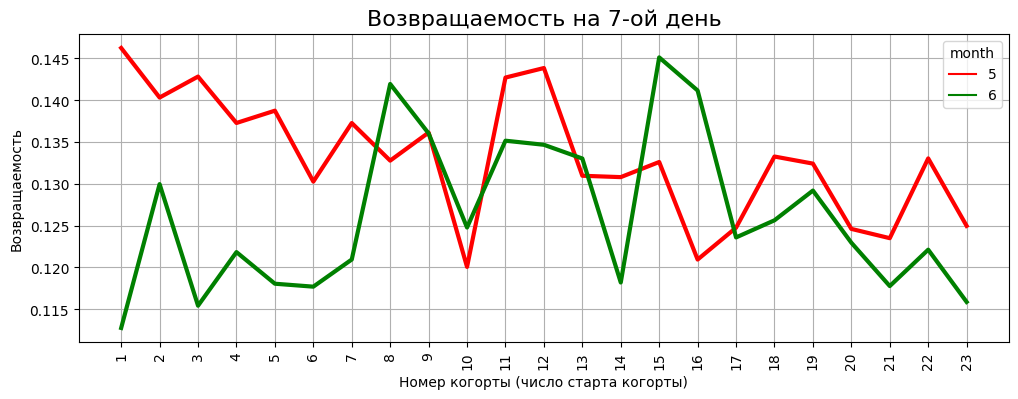

In [12]:
#retention_pivot[7].plot.bar()
cohorts=range(1,24)
fig_retention_on_day_7 = plt.figure(figsize=(12, 4))
lineplot = sns.lineplot(
    data=retention_7_table,
    x='cohort_#',
    y='retention_rate',
    hue='month',
    #orient='v',
    #width=0.5,
    palette={5:'r', 6:'g'},
    #estimator=None,
    linewidth=3
)
lineplot.set_title('Возвращаемость на 7-ой день', fontsize=16);
lineplot.set_xlabel('Номер когорты (число старта когорты)');
lineplot.set_ylabel('Возвращаемость');
lineplot.xaxis.set_tick_params(rotation=90)
lineplot.set_xticks(cohorts, minor=False);
lineplot.grid() ;
#lineplot.fill_between()

**ВЫВОД**:   
По обоим месяцам возвращаемость сильно разнится от когорты к когорте, однако в целом можно отметить следующее:
- Возвращаемость в когортах начала **мая** была высокой, затем падала до конца 1-ой декады. В начале 2-ой декады наблюдается кратковременный рост возвращаемости. Далее возвращаемость падает и после этого стабализируется с середины 2-ой декады.
- Возвращаемость в когортах начала **июня** была крайне низкой, в конце 1-ой декады резко выросла, но с середины 2-ой декады резко упала, после чего продолжилось плавное падение.

Разобъем полученную таблицу на две - с данными по маю (до внедрения нового релиза) и по июню (после внедрения):

In [13]:
retention_7_may=retention_7_table[retention_7_table['month'] == 5]
retention_7_june=retention_7_table[retention_7_table['month'] == 6]
display(retention_7_may)
display(retention_7_june)

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,cohort_#,month
0,2019-05-08,2019-05-01,953,6516,0.146255,7,1,5
9,2019-05-09,2019-05-02,745,5309,0.140328,7,2,5
...,...,...,...,...,...,...,...,...
384,2019-05-29,2019-05-22,771,5795,0.133046,7,22,5
408,2019-05-30,2019-05-23,682,5457,0.124977,7,23,5


,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,cohort_#,month
424,2019-06-08,2019-06-01,545,4833,0.112766,7,1,6
447,2019-06-09,2019-06-02,683,5255,0.129971,7,2,6
...,...,...,...,...,...,...,...,...
913,2019-06-29,2019-06-22,351,2874,0.122129,7,22,6
937,2019-06-30,2019-06-23,359,3098,0.115881,7,23,6


Объединим горизонтально таблицы по маю и июню по номеру когорты, предварительно переименовав столбцы с количеством клиентов и столбцы retention_rate:

In [14]:
retention_7_may.rename(columns={'retention_rate':'retention_rate_may','active_users_count':'active_users_count_may', \
    'registered_users_count':'registered_users_count_may'}, inplace=True)
retention_7_june.rename(columns={'retention_rate':'retention_rate_june','active_users_count':'active_users_count_june', \
    'registered_users_count':'registered_users_count_june'}, inplace=True)
may_vs_june_retention_7 = retention_7_may.merge(retention_7_june,on=['cohort_#'])
print('Объединенная таблица со всей информацией:')
display(may_vs_june_retention_7)

Объединенная таблица со всей информацией:


C:\Users\AlexeySch\AppData\Local\Temp\ipykernel_22408\2775364517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retention_7_may.rename(columns={'retention_rate':'retention_rate_may','active_users_count':'active_users_count_may', \
C:\Users\AlexeySch\AppData\Local\Temp\ipykernel_22408\2775364517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retention_7_june.rename(columns={'retention_rate':'retention_rate_june','active_users_count':'active_users_count_june', \


,activity_date_x,registration_date_x,active_users_count_may,registered_users_count_may,retention_rate_may,lifetime_x,cohort_#,month_x,activity_date_y,registration_date_y,active_users_count_june,registered_users_count_june,retention_rate_june,lifetime_y,month_y
0,2019-05-08,2019-05-01,953,6516,0.146255,7,1,5,2019-06-08,2019-06-01,545,4833,0.112766,7,6
1,2019-05-09,2019-05-02,745,5309,0.140328,7,2,5,2019-06-09,2019-06-02,683,5255,0.129971,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,2019-05-29,2019-05-22,771,5795,0.133046,7,22,5,2019-06-29,2019-06-22,351,2874,0.122129,7,6
22,2019-05-30,2019-05-23,682,5457,0.124977,7,23,5,2019-06-30,2019-06-23,359,3098,0.115881,7,6


Уберем лишние столбцы из полученной таблицы:

In [15]:
may_vs_june_retention_7.drop(labels = ['activity_date_x','registration_date_x','lifetime_x', \
    'activity_date_y','registration_date_y','lifetime_y','month_x','month_y'],axis=1, inplace=True)
display(may_vs_june_retention_7)

,active_users_count_may,registered_users_count_may,retention_rate_may,cohort_#,active_users_count_june,registered_users_count_june,retention_rate_june
0,953,6516,0.146255,1,545,4833,0.112766
1,745,5309,0.140328,2,683,5255,0.129971
...,...,...,...,...,...,...,...
21,771,5795,0.133046,22,351,2874,0.122129
22,682,5457,0.124977,23,359,3098,0.115881


Добавим столбец с разницей возвращаемости между майскими и июньскими когортами:

In [16]:
may_vs_june_retention_7['may-jun_retantion_rate_diff']=may_vs_june_retention_7['retention_rate_may'] \
    - may_vs_june_retention_7['retention_rate_june']
display(may_vs_june_retention_7)

,active_users_count_may,registered_users_count_may,retention_rate_may,cohort_#,active_users_count_june,registered_users_count_june,retention_rate_june,may-jun_retantion_rate_diff
0,953,6516,0.146255,1,545,4833,0.112766,0.033489
1,745,5309,0.140328,2,683,5255,0.129971,0.010356
...,...,...,...,...,...,...,...,...
21,771,5795,0.133046,22,351,2874,0.122129,0.010916
22,682,5457,0.124977,23,359,3098,0.115881,0.009096


In [17]:
may_vs_june_retention_7.insert(0,'cohort #',may_vs_june_retention_7.pop('cohort_#'))
may_vs_june_retention_7.insert(1,'retention rate may',may_vs_june_retention_7.pop('retention_rate_may'))
may_vs_june_retention_7.insert(2,'retention rate jun',may_vs_june_retention_7.pop('retention_rate_june'))
may_vs_june_retention_7.insert(3,'may-jun retantion rate diff',may_vs_june_retention_7.pop('may-jun_retantion_rate_diff'))
may_vs_june_retention_7.insert(4,'reg users cnt may',may_vs_june_retention_7.pop('registered_users_count_may'))
may_vs_june_retention_7.insert(5,'reg users cnt jun',may_vs_june_retention_7.pop('registered_users_count_june'))
may_vs_june_retention_7.insert(6,'active users cnt may',may_vs_june_retention_7.pop('active_users_count_may'))
may_vs_june_retention_7.insert(7,'active users cnt jun',may_vs_june_retention_7.pop('active_users_count_june'))
pd.set_option('display.max_rows', 25)
print('Число зарегестрированных пользователей в когорте, число активных пользователей на 7-ой день и возвращаемость на 7-ой день по когортам мая и июня (до и после внедрения нового релиза):')
display(may_vs_june_retention_7)

Число зарегестрированных пользователей в когорте, число активных пользователей на 7-ой день и возвращаемость на 7-ой день по когортам мая и июня (до и после внедрения нового релиза):


,cohort #,retention rate may,retention rate jun,may-jun retantion rate diff,reg users cnt may,reg users cnt jun,active users cnt may,active users cnt jun
0,1,0.146255,0.112766,0.033489,6516,4833,953,545
1,2,0.140328,0.129971,0.010356,5309,5255,745,683
2,3,0.142834,0.115430,0.027404,6266,4193,895,484
3,4,0.137284,0.121841,0.015444,8639,4194,1186,511
4,5,0.138755,0.118059,0.020696,9787,3998,1358,472
5,6,0.130274,0.117707,0.012567,7561,3908,985,460
6,7,0.137280,0.120955,0.016325,6199,3183,851,385
7,8,0.132782,0.141948,-0.009166,6650,2987,883,424
8,9,0.136138,0.136039,0.000098,5634,4484,767,610
9,10,0.120069,0.124782,-0.004713,5247,4007,630,500


Расчитаем медианную и среднюю возвращаемость на 7-ой день для майских и июньских когорт:

In [18]:
may_med=may_vs_june_retention_7['retention rate may'].median()
jun_med=may_vs_june_retention_7['retention rate jun'].median()
may_avg=may_vs_june_retention_7['retention rate may'].mean()
jun_avg=may_vs_june_retention_7['retention rate jun'].mean()
retantion_7_stat = pd.DataFrame(
    data = [
        [may_med, may_avg],
        [jun_med, jun_avg],
        [jun_med - may_med,jun_avg - may_avg]
        ],
    columns= ['median', 'average'],
    index = ['May', 'June','diff']
)
print('Медианный и средний коэфициент возвращаемости на 7-ой день по когортам мая (до нового релиза) и июня (после нового релиза):')
display(retantion_7_stat)
print('Изменение медианной возвращаемости от мая к июню :   ', \
    round(retantion_7_stat.iloc[2][0]/retantion_7_stat.iloc[0][0]*100,2),'%')
print('Изменение средней возвращаемости от мая к июню   :   ', \
    round(retantion_7_stat.iloc[2][1]/retantion_7_stat.iloc[0][1]*100,2),'%')

Медианный и средний коэфициент возвращаемости на 7-ой день по когортам мая (до нового релиза) и июня (после нового релиза):


,median,average
May,0.132782,0.133066
June,0.123596,0.126264
diff,-0.009186,-0.006802


Изменение медианной возвращаемости от мая к июню :    -6.92 %
Изменение средней возвращаемости от мая к июню   :    -5.11 %


**ВЫВОД**:  
Как средняя, так и медианная возвращаемость на 7-ой день по когортам мая чуть выше аналогичных показателей июня.

## Расчитаем ARPPU

**Подход к решению задачи**:  
Посчитаем ARPPU следующим образом:
- ARPPU в мае посчитаем с 1 по 30 мая от клиентов, зарегестрировавшихся с 1 по 23 мая;
- ARPPU в июне посчитаем с 1 по 30 июня от клиентов, зарегестрировавшихся с 1 по 23 июня.  

Как и в случае с расчетом retention rate, отсчечение 31 мая сделано для сравнимости результатов мая и июня (где только 30 дней).

Получим из SQL базы данных информацию о суммарной выручке и количестве следующих платящих клинтов:
- зарегистрировавшихся с 1 по 23 мая и сделавших заказы с 1 по 30 мая;
- зарегистрировавшихся с 1 по 23 июня и сделавших заказы с 1 по 30 июня.

Преобразуем результат в таблицу DataFrame revenue:

In [19]:
def getRevenue():
    query = '''SELECT EXTRACT(MONTH FROM r.registration_date) AS month, count(distinct(re.user_id)) as "paying users cnt", sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE (r.registration_date between '2019-05-01' and '2019-05-23' and re.date between '2019-05-01' and '2019-05-30')
        or (r.registration_date between '2019-06-01' and '2019-06-23' and re.date between '2019-06-01' and '2019-06-30')
    GROUP BY 1
    ''' #.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue = pd.DataFrame(getRevenue())
print('Количество платящих клиентов и выручка по месяцам:')
display(revenue)

Количество платящих клиентов и выручка по месяцам:


,month,paying users cnt,revenue
0,5.0,122139,82287.4
1,6.0,68269,58232.0


Добавим в полученную таблицу столбец ARPPU:

In [20]:
revenue['ARPPU'] = revenue['revenue'] / revenue['paying users cnt'] 
display(revenue)

,month,paying users cnt,revenue,ARPPU
0,5.0,122139,82287.4,0.673719
1,6.0,68269,58232.0,0.852979


Расчитаем разницу между месяцами:

In [21]:
arppu_stat = pd.DataFrame(
    data = [
        [revenue['paying users cnt'][0],revenue['revenue'][0],revenue['ARPPU'][0]],
        [revenue['paying users cnt'][1],revenue['revenue'][1],revenue['ARPPU'][1]],
        [revenue['paying users cnt'][1]-revenue['paying users cnt'][0], \
            revenue['revenue'][1]-revenue['revenue'][0],revenue['ARPPU'][1]-revenue['ARPPU'][0]],
        ],
    columns= ['paying users cnt','revenue','ARPPU'],
    index = ['May', 'June','diff']
)
print('Медианный и средний коэфициент возвращаемости на 7-ой день по когортам мая (до нового релиза) и июня (после нового релиза):')
display(arppu_stat)
print('Изменение количества платящих клиентов от мая к июню :   ', round(arppu_stat.iloc[2][0]/arppu_stat.iloc[0][0]*100,2),'%')
print('Изменение выручки от мая к июню                      :   ', round(arppu_stat.iloc[2][1]/arppu_stat.iloc[0][1]*100,2),'%')
print('Изменение ARPPU от мая к июню                        :    ', round(arppu_stat.iloc[2][2]/arppu_stat.iloc[0][2]*100,2),'%')

Медианный и средний коэфициент возвращаемости на 7-ой день по когортам мая (до нового релиза) и июня (после нового релиза):


,paying users cnt,revenue,ARPPU
May,122139,82287.4,0.673719
June,68269,58232.0,0.852979
diff,-53870,-24055.4,0.179259


Изменение количества платящих клиентов от мая к июню :    -44.11 %
Изменение выручки от мая к июню                      :    -29.23 %
Изменение ARPPU от мая к июню                        :     26.61 %


**ВЫВОД**:  
Количество платящих клиентов и выручка от них в июне были меньше чем в мае, но ARPPU при этом вырос на 26,61%.

## Подытожим выводы.
**Retantion Rate**.
1. По обоим месяцам возвращаемость сильно разнится от когорты к когорте, однако в целом можно отметить следующее:
   - Возвращаемость в когортах начала **мая** была высокой, затем падала до конца 1-ой декады. В начале 2-ой декады наблюдается кратковременный рост возвращаемости. Далее возвращаемость падает и после этого стабализируется с середины 2-ой декады.
   - Возвращаемость в когортах начала **июня** была крайне низкой, в конце 1-ой декады резко выросла, но с середины 2-ой декады резко упала, после чего продолжилось плавное падение.
2. Возвращаемость в июне немного меньше чем в мае - как средняя, так и медианная возвращаемость на 7-ой день по когортам июня чуть ниже аналогичных показателей июня:
   - Изменение медианной возвращаемости от мая к июню :    -6.92 %
   - Изменение средней возвращаемости от мая к июню   :    -5.11 %  

**ARPPU**.  
1. Количество платящих клиентов и выручка от них в июне были меньше чем в мае, но ARPPU при этом вырос на 26,61%.

**Итого**: 
Несмотря на небольшое падение возвращаемости, ARPPU в июне вырос на 26,6% по отношению к маю.
